In [1]:
# Parameters
image_path = "input_image.png"


In [2]:
# Parameter Cell
try:
    image_path
except NameError:
    image_path = 'flowchart.jpeg'  # Default value only if not externally passed

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## 1. Loading Input Image

In [4]:
fc = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
rows, columns = fc.shape[:2]

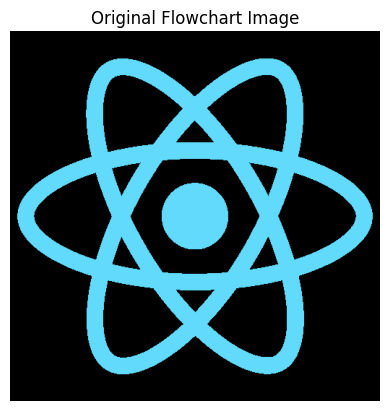

In [5]:
plt.imshow(fc)
plt.axis('off')
plt.title("Original Flowchart Image")
plt.show()

## 2. Binarize
- Convert to grayscale
- Adaptive thresholding
- Bitwise inversion

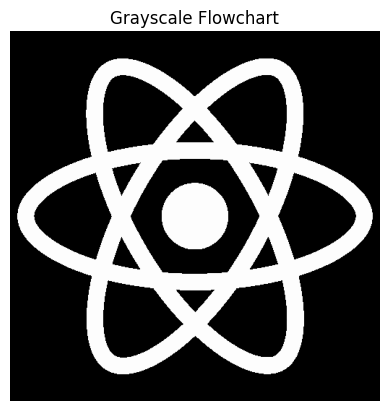

In [6]:
fc_gray = cv2.cvtColor(fc, cv2.COLOR_RGB2GRAY)
plt.imshow(fc_gray, cmap="gray")
plt.axis('off')
plt.title("Grayscale Flowchart")
plt.show()

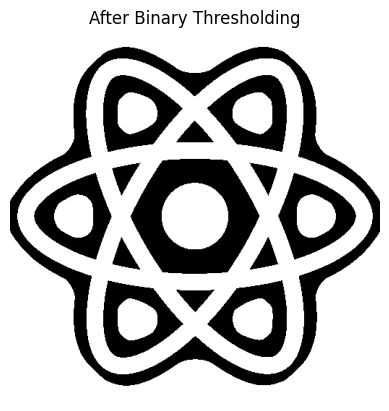

In [7]:
fc_binary = cv2.adaptiveThreshold(fc_gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY, 65, 40)
plt.imshow(fc_binary, cmap="gray")
plt.axis('off')
plt.title("After Binary Thresholding")
plt.show()

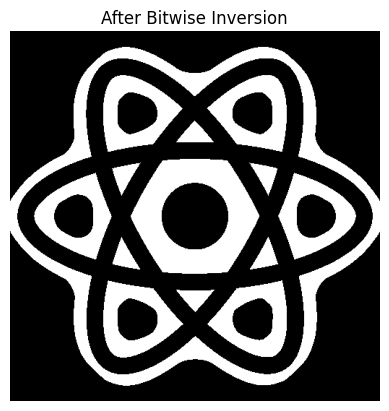

In [8]:
fc_bitInvert = cv2.bitwise_not(fc_binary)
plt.imshow(fc_bitInvert, cmap="gray")
plt.axis('off')
plt.title("After Bitwise Inversion")
plt.show()

## 3. Denoising

In [9]:
def denoise_and_fill(img, threshold):
        contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        denoised = np.zeros_like(img)
        for contour in contours:
            if cv2.contourArea(contour) > threshold:
                cv2.drawContours(denoised, [contour], -1, 255, thickness=cv2.FILLED)
        return denoised

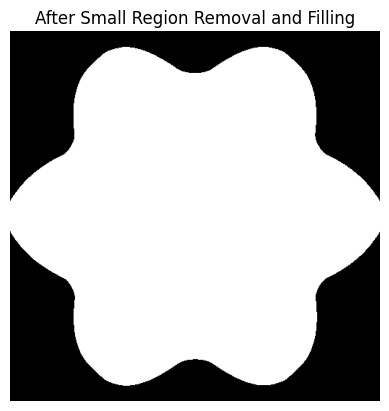

In [10]:
fc_denoised = denoise_and_fill(fc_bitInvert,100)
plt.imshow(fc_denoised, cmap="gray")
plt.axis('off')
plt.title("After Small Region Removal and Filling")
plt.show()

## 4. Hough Transform and Rotation
- Edge detection
- Finding primary angle
- Resize and rotating image

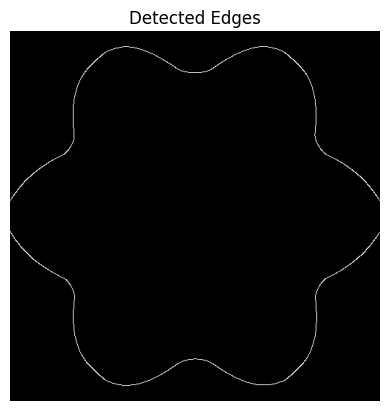

In [11]:
fc_edges = cv2.Canny(fc_denoised, 100, 100, apertureSize=3, L2gradient=False)
plt.imshow(fc_edges, cmap="gray")
plt.axis('off')
plt.title("Detected Edges")
plt.show()

In [12]:
def get_primary_angle(img):
    lines =  cv2.HoughLinesP(img, 1, np.pi / 180.0, 50, minLineLength=30 ,maxLineGap=5)
    angles = []
    for line in lines:
        for x1, y1, x2, y2 in line:
            angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))
            angles.append(angle)
    angles.sort()
    angles = np.array(angles)
    bins = np.linspace(-90, 90, 12)
    hist, bin_edges = np.histogram(angles, bins)
    max_bin = np.argmax(hist)
    mask = (angles>= bin_edges[max_bin]) & (angles < bin_edges[max_bin+1])
    majority_angles = angles[mask]
    primary_angle = np.median(majority_angles)
    plt.hist(angles, bins=bins, edgecolor='black')
    plt.title(f"Histogram of Angles (Primary Angle : {primary_angle:.2f}deg)")
    return primary_angle

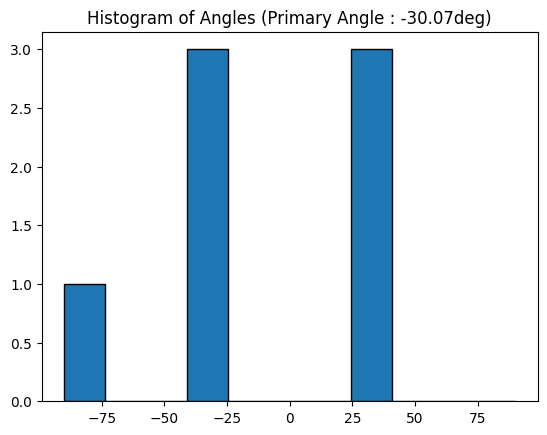

In [13]:
fc_angle = get_primary_angle(fc_edges)

In [14]:
def rotate_orientation(img, angle):
    h, w = img.shape
    center = (w // 2, h // 2)
    rotMat = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(img, rotMat, (w, h), flags=cv2.INTER_LINEAR)
    return rotated

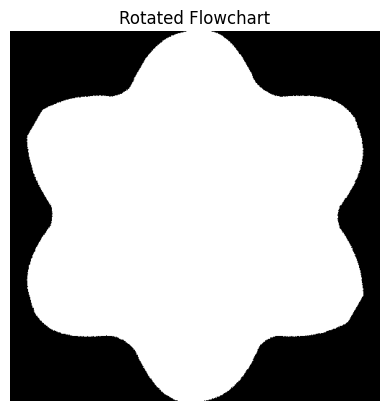

In [15]:
fc_rotated = rotate_orientation(fc_denoised, fc_angle)
fc_rotated = denoise_and_fill(fc_rotated, 100)
plt.imshow(fc_rotated, cmap="gray")
plt.axis('off')
plt.title("Rotated Flowchart")
plt.show()

## 5. Decomposition

In [16]:
def SE_opening(radius):
        diameter = 2 * radius + 1
        se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (diameter, diameter))
        return se

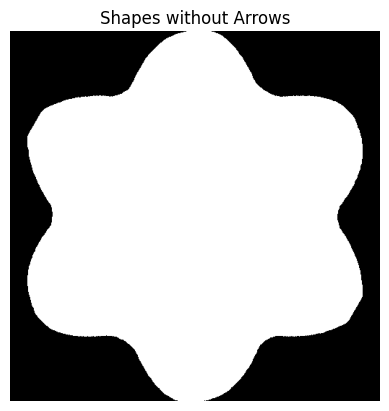

In [17]:
fc_rotated = denoise_and_fill(fc_rotated, 100)
fc_opened = cv2.morphologyEx(fc_rotated, cv2.MORPH_OPEN, SE_opening(10))
fc_opened = denoise_and_fill(fc_opened, 100)
plt.imshow(fc_opened, cmap="gray")
plt.axis('off')
plt.title("Shapes without Arrows")
plt.show()
fc_shapes = fc_opened

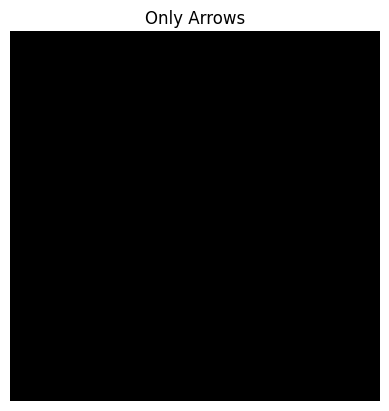

In [18]:
fc_arrows = cv2.absdiff(fc_rotated, fc_shapes)
fc_arrows = denoise_and_fill(fc_arrows, 100)
plt.imshow(fc_arrows, cmap="gray")
plt.axis('off')
plt.title("Only Arrows")
plt.show()

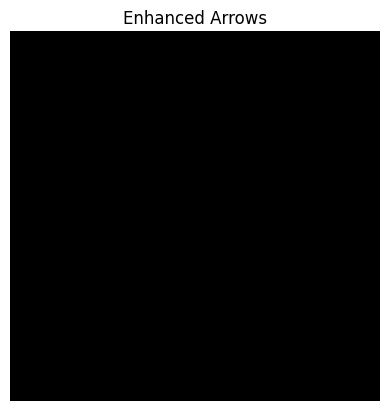

In [19]:
fc_arrows_enhanced = cv2.dilate(fc_arrows, SE_opening(2))
plt.imshow(fc_arrows_enhanced, cmap="gray")
plt.axis('off')
plt.title("Enhanced Arrows")
plt.show()

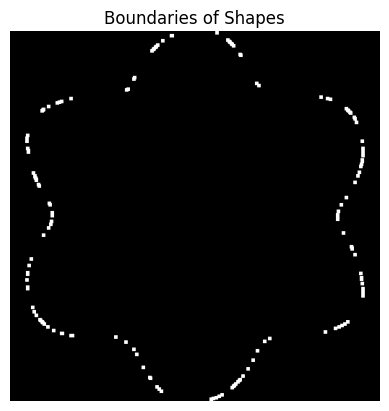

In [20]:
shapes = cv2.absdiff(fc_rotated, fc_arrows)
fc_boundaries = cv2.absdiff(shapes, fc_opened)
fc_boundaries = cv2.dilate(fc_boundaries, np.ones((5, 5)), iterations=1)
plt.imshow(fc_boundaries, cmap="gray")
plt.axis('off')
plt.title("Boundaries of Shapes")
plt.show()
fc_boundaries_copy = fc_boundaries.copy()

## 6. Classification

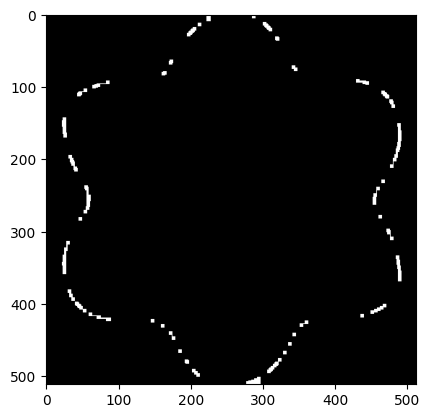

In [21]:
kernel = np.ones((20, 20), np.uint8)  # Adjust kernel size as needed

# Apply morphological closing to connect gaps
closed = cv2.morphologyEx(fc_boundaries, cv2.MORPH_CLOSE, kernel)
plt.imshow(closed, cmap="gray")

In [22]:
contours, _ = cv2.findContours(fc_boundaries, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for contour in contours:
    temp = np.zeros_like(fc_boundaries)
    cv2.drawContours(temp, [contour], -1, 255, 10)
    circles = cv2.HoughCircles(temp, cv2.HOUGH_GRADIENT, 2,
                               fc_rotated.shape[0]/4, param1=200,
                               param2=100, minRadius=0, maxRadius=5)
    if circles is not None and len(circles) > 0:
        print("aha")
        cv2.fillPoly(fc_boundaries_copy, [contour], 0)
circ = cv2.absdiff(fc_boundaries, fc_boundaries_copy)

In [23]:
print(len(contours))

67


In [24]:
output = fc_rotated.copy()
for contour in contours:
    # Get the perimeter and area of the contour
    perimeter = cv2.arcLength(contour, True)
    area = cv2.contourArea(contour)
    
    if perimeter == 0:
        continue  # Avoid division by zero
    
    # Calculate circularity
    circularity = 4 * np.pi * (area / (perimeter ** 2))
    # Check if circularity is close to 1 (ideal for a circle)
    if 0.8 < circularity < 1.1:
        print("YEEEEEEE")
        # Draw the contour (circle-like shape)
        cv2.drawContours(output, [contour], -1, (0, 255, 0), 8)
        
        # Optionally, draw a bounding circle
        (x, y), radius = cv2.minEnclosingCircle(contour)
        center = (int(x), int(y))
        cv2.circle(output, center, int(radius), (255, 255, 255), 10)

YEEEEEEE
YEEEEEEE
YEEEEEEE


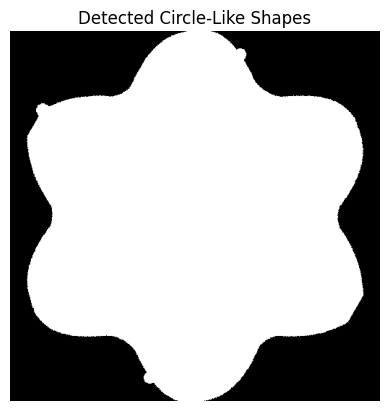

In [25]:
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.title('Detected Circle-Like Shapes')
plt.axis('off')
plt.show()

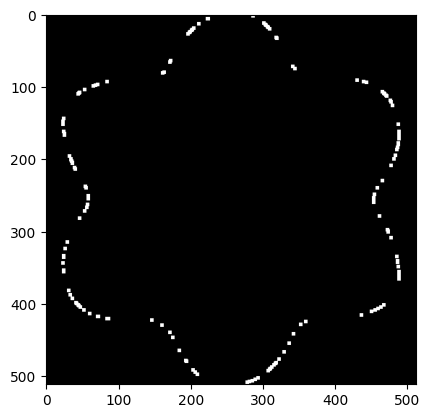

In [26]:
plt.imshow(fc_boundaries_copy, cmap='gray')

In [27]:
cv2.imwrite('output.png', fc_boundaries_copy)

True

In [28]:


            # # Extract rectangles and diamonds
            # blob = cv2.absdiff(fill, remv)
            # print("Blob Done!")
            # PrePro.saveImage(fill, "fill")

            # # Find circles
            # eroded_blob = PrePro.erode(blob, 10)
            # diff_blob = cv2.absdiff(blob, eroded_blob)
            # copy_blob = diff_blob.copy()
            # PrePro.saveImage(diff_blob, "diff_blob")

            # contours, _ = cv2.findContours(diff_blob, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            # for contour in contours:
            #     temp = np.zeros_like(diff_blob)
            #     cv2.drawContours(temp, [contour], -1, 255, 10)
            #     circles = cv2.HoughCircles(temp, cv2.HOUGH_GRADIENT, 2,
            #                                substitute.shape[0]/4, param1=200,
            #                                param2=100, minRadius=0, maxRadius=0)
            #     if circles is not None and len(circles) > 0:
            #         print("aha")
            #         cv2.fillPoly(copy_blob, [contour], 0)
            # circ = cv2.absdiff(diff_blob, copy_blob)
            # PrePro.saveImage(copy_blob, "copy_blob")

            # # Distinguish rectangles and diamonds
            # rect, diam = PrePro.genRectAndDiam(copy_blob)

            # # Erode
            # eroded_rect = PrePro.erode(rect, 10)
            # eroded_diam = PrePro.erode(diam, 10)
            # PrePro.saveImage(eroded_rect, "eroded_rect")
            # PrePro.saveImage(eroded_diam, "eroded_diam")

            # # Get final rectangles and diamonds
            # rect = cv2.absdiff(rect, eroded_rect)
            # diam = cv2.absdiff(diam, eroded_diam)
            # print("Box Done!")

            # # Prepare result
            # result = [rect, diam, arro, circ]
            # print("Conversion Done!")
            # return result